In [29]:
import importlib
import loaders.load_tradeweb  # the module you imported earlier
importlib.reload(loaders.load_tradeweb)

<module 'loaders.load_tradeweb' from 'e:\\bond_project\\loaders\\load_tradeweb.py'>

In [25]:
from datetime import datetime
from database.db import get_conn

DB_PATH = "jcb_db.db"
SOURCE_TO_CLEAR = "tradeweb"   # case-insensitive

# --- run this cell ---
with get_conn(DB_PATH) as conn:
    # 1) quick audit before
    before_by_source = conn.execute("""
        SELECT LOWER(source) as source, COUNT(*) 
        FROM instrument_data 
        GROUP BY LOWER(source) 
        ORDER BY 1
    """).fetchall()
    print("Before (instrument_data):", before_by_source)

    # 2) backup current instrument_data (timestamped table)
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup_table = f"instrument_data_backup_{stamp}"
    conn.execute(f"CREATE TABLE {backup_table} AS SELECT * FROM instrument_data;")
    print(f"Backup created: {backup_table}")

    # 3) delete from instrument_data
    n_del_main = conn.execute(
        "SELECT COUNT(*) FROM instrument_data WHERE LOWER(source)=?", (SOURCE_TO_CLEAR,)
    ).fetchone()[0]
    conn.execute("DELETE FROM instrument_data WHERE LOWER(source)=?", (SOURCE_TO_CLEAR,))
    print(f"Deleted from instrument_data: {n_del_main}")

    # 4) if a normalised table exists, clear it too (optional but tidy)
    has_norm = conn.execute("""
        SELECT 1 FROM sqlite_master WHERE type='table' AND name='instrument_data_norm'
    """).fetchone() is not None
    if has_norm:
        n_del_norm = conn.execute(
            "SELECT COUNT(*) FROM instrument_data_norm WHERE LOWER(source)=?", (SOURCE_TO_CLEAR,)
        ).fetchone()[0]
        conn.execute("DELETE FROM instrument_data_norm WHERE LOWER(source)=?", (SOURCE_TO_CLEAR,))
        print(f"Deleted from instrument_data_norm: {n_del_norm}")

    # 5) audit after
    after_by_source = conn.execute("""
        SELECT LOWER(source) as source, COUNT(*) 
        FROM instrument_data 
        GROUP BY LOWER(source) 
        ORDER BY 1
    """).fetchall()
    print("After (instrument_data):", after_by_source)

# Optional: reclaim file space (run once, outside the transaction)
import sqlite3
with sqlite3.connect(DB_PATH) as conn_raw:
    conn_raw.execute("VACUUM;")
    print("VACUUM complete.")


Before (instrument_data): [<sqlite3.Row object at 0x000001D4C45C7760>, <sqlite3.Row object at 0x000001D4C45C6D10>, <sqlite3.Row object at 0x000001D4C45C6260>, <sqlite3.Row object at 0x000001D4C45C6D40>]
Backup created: instrument_data_backup_20250902_170156
Deleted from instrument_data: 14294
Deleted from instrument_data_norm: 14294
After (instrument_data): [<sqlite3.Row object at 0x000001D4C45C4D30>, <sqlite3.Row object at 0x000001D4C45C6290>, <sqlite3.Row object at 0x000001D4C45C5420>]
VACUUM complete.


In [22]:
from database.normalise_types import normalise_instrument_data

with get_conn(DB_PATH) as conn:
    normalise_instrument_data(conn)

In [34]:
from loaders.compare_sources import compare_source_series

# 5) Compare Bloomberg vs Tradeweb (canonical types)
isin = "GB00B1VWPJ53"
cmp_price = compare_source_series(DB_PATH, isin, data_type="clean_price", start="2025-03-15", end="2025-04-15")
cmp_yield = compare_source_series(DB_PATH, isin, data_type="yield", start="2025-03-15", end="2025-04-15")
display(cmp_price.tail(8))
display(cmp_yield.tail(8))

source,Bloomberg,Tradeweb,diff,diff_bp
data_date,,,,
2025-04-04,94.921,94.84,-0.081,-8.1
2025-04-07,92.812,92.96,0.148,14.8
2025-04-08,92.699,92.67,-0.029,-2.9
2025-04-09,90.303,90.81,0.507,50.7
2025-04-10,91.914,92.11,0.196,19.6
2025-04-11,90.869,90.92,0.051,5.1
2025-04-14,92.122,92.06,-0.062,-6.2
2025-04-15,91.845,91.87,0.025,2.5


source,Bloomberg,Tradeweb,diff,diff_bp
data_date,,,,
2025-04-04,4.934,4.940696,0.006696,0.6696
2025-04-07,5.123,5.109270,-0.013730,-1.3730
2025-04-08,5.133,5.135728,0.002728,0.2728
2025-04-09,5.355,5.307681,-0.047319,-4.7319
2025-04-10,5.205,5.187147,-0.017853,-1.7853
2025-04-11,5.303,5.297733,-0.005267,-0.5267
2025-04-14,5.186,5.192047,0.006047,0.6047
2025-04-15,5.212,5.209635,-0.002365,-0.2365


In [ ]:
import sqlite3

db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Update yield_nominal to yield
cursor.execute("""
    UPDATE instrument_data
    SET data_type = 'yield'
    WHERE data_type = 'yield_nominal';
""")

# Update resolution to daily_close
cursor.execute("""
    UPDATE instrument_data
    SET resolution = 'daily_close'
    WHERE resolution = 'daily';
""")

conn.commit()
conn.close()
print("✅ instrument_data table updated.")

In [ ]:
import sqlite3
import pandas as pd
import importlib

import database.insert # the module you imported earlier
importlib.reload(database.insert)

from database.insert import insert_instrument_identifier

file_path = "ISIN_to_BBerg.xlsx"
db_path = "jcb_db.db"

df = pd.read_excel(file_path)
conn = sqlite3.connect(db_path)

inserted = 0
skipped = 0
errors = []

for _, row in df.iterrows():
    try:
        isin = str(row["ISIN"]).strip()

        mappings = [
            (row.get("ISIN"), "ISIN"),
            (row.get("Bloomberg Ticker"), "Bloomberg"),
            (row.get("Short Code"), "Short Code"),
            (row.get("Short Code 2"), "Short Code 2")
        ]

        for id_value, source in mappings:
            if pd.notna(id_value):
                id_str = str(id_value).strip()
                result = insert_instrument_identifier(conn, isin, id_str, source)
                if result == "inserted":
                    inserted += 1
                else:
                    skipped += 1

    except Exception as e:
        errors.append(str(e))

conn.close()

print(f"✅ Mappings loaded: {inserted} inserted, {skipped} skipped.")
if errors:
    print(f"⚠️ Errors: {len(errors)}")
    for err in errors:
        print(" -", err)

In [ ]:
import importlib

import database.schema # the module you imported earlier
importlib.reload(database.schema)

from database.schema import create_calendar_holidays_table

create_calendar_holidays_table



In [ ]:
file_path = "ISIN_to_BBerg.xlsx"

df = pd.read_excel(file_path)

In [ ]:
df

In [15]:
# --- Bloomberg Excel loader (connection-based; per-row inserts) ---
import sys, sqlite3
sys.path.append("/Users/jcb/Documents/bond_project")  # adjust if needed

import pandas as pd
from datetime import datetime, timedelta

from database.query import resolve_isin_from_alt_id
from database.insert import insert_instrument_data   # expects ONE InstrumentData
from models.instrument_data import InstrumentData

DB_PATH   = "/Volumes/PROJECT_JCB/bond_project/jcb_db.db"
FILE_PATH = "Price_History_HC.xlsx"

# Config
PRICE_AS_CLEAN = True      # PX_LAST -> 'clean_price' (else 'price')
SESSION        = "close"   # mark close session in attrs
RESOLUTION     = "daily"   # your queries expect 'daily'
BATCH_SIZE     = 5000      # just controls memory; inserts are still per-row

def excel_serial_to_date(serial):
    return (datetime(1899, 12, 30) + timedelta(days=float(serial))).date()

def clean_date(cell):
    try:
        if isinstance(cell, (int, float)) and 10000 < float(cell) < 60000:
            return excel_serial_to_date(cell)
        d = pd.to_datetime(cell, errors="coerce")
        return None if pd.isna(d) else d.date()
    except Exception:
        return None

def map_bbg_dtype(raw: str) -> str:
    r = (raw or "").strip().lower()
    if r == "yld_ytm_mid":
        return "yield"
    if r == "px_dirty_mid":
        return "dirty_price"
    if r == "px_last":
        return "clean_price" if PRICE_AS_CLEAN else "price"
    # extend mappings as needed (e.g., DUR_MID -> duration_modified)
    return r or "price"

def unit_for_dtype(dt: str):
    if dt == "yield": return "percent"
    if dt in ("clean_price","dirty_price","price"): return "per_100"
    if dt in ("z_spread","ois_oas"): return "bps"
    if dt in ("duration_modified","modified_duration"): return "years"
    return None

# Load workbook (4-column block layout)
df = pd.read_excel(FILE_PATH, header=None)

start_col = 2
errors   = []
inserted = 0
skipped  = 0
batch    = []

def flush_batch(conn, batch):
    global inserted, skipped
    for row in batch:
        try:
            res = insert_instrument_data(conn, row)  # your helper expects ONE InstrumentData
            inserted += 1 if res == "inserted" else 0
            skipped  += 1 if res != "inserted" else 0
        except Exception as e:
            errors.append(f"{row.instrument_id} @ {row.data_date}: {e}")

conn = sqlite3.connect(DB_PATH)
try:
    # sensible PRAGMAs
    conn.execute("PRAGMA foreign_keys=ON;")
    conn.execute("PRAGMA journal_mode=WAL;")
    conn.execute("PRAGMA synchronous=NORMAL;")
    conn.execute("PRAGMA busy_timeout=5000;")

    conn.execute("BEGIN;")

    col = start_col
    while col < df.shape[1]:
        try:
            bloomberg_code = str(df.iloc[4, col]).strip()
            short_code     = str(df.iloc[5, col]).strip()
            data_type_raw  = str(df.iloc[6, col]).strip()
            data_type      = map_bbg_dtype(data_type_raw)

            # Resolve ISIN using the SAME connection
            isin = resolve_isin_from_alt_id(conn, bloomberg_code, source="Bloomberg")
            if not isin:
                errors.append(f"{bloomberg_code}: ISIN not found")
                col += 4
                continue

            date_series  = df.iloc[10:, col]
            value_series = df.iloc[10:, col + 1]

            for date_cell, value_cell in zip(date_series, value_series):
                d = clean_date(date_cell)
                if d is None or pd.isna(value_cell):
                    continue
                try:
                    val = float(value_cell)
                except Exception:
                    continue

                batch.append(InstrumentData(
                    instrument_id=isin,
                    data_date=d,
                    data_type=data_type,
                    value=val,
                    source="Bloomberg",
                    resolution=RESOLUTION,
                    unit=unit_for_dtype(data_type),
                    attrs={"session": SESSION}
                ))

                if len(batch) >= BATCH_SIZE:
                    flush_batch(conn, batch)
                    batch.clear()

        except Exception as outer_e:
            errors.append(f"Column {col}: {outer_e}")

        col += 4  # next block

    if batch:
        flush_batch(conn, batch)
        batch.clear()

    conn.execute("COMMIT;")
except Exception as e:
    conn.execute("ROLLBACK;")
    raise
finally:
    conn.close()

print("✅ Finished loading Bloomberg historical data (connection-based, per-row insert).")
print(f"   Inserted: {inserted} | Skipped: {skipped} | Errors: {len(errors)}")
for e in errors[:10]:
    print(" -", e)
if len(errors) > 10:
    print(f"   ...and {len(errors)-10} more.")



✅ Finished loading Bloomberg historical data (connection-based, per-row insert).
   Inserted: 166316 | Skipped: 93886 | Errors: 4
 - YL132268 Corp: ISIN not found
 - NaT: ISIN not found
 - NaT: ISIN not found
 - NaT: ISIN not found


In [8]:
print(df.head(20))


              0           1                    2         3               4    \
0             NaN  start date  2015-09-11 00:00:00       NaN         no inst   
1             NaN    end date  2025-09-11 00:00:00       NaN  worksheet name   
2             NaN         NaN                  NaN       NaN      sheet name   
3             NaN         NaN                    1       NaN             NaN   
4              id           2        ZN905725 Corp       NaN             NaN   
5      short_name          14               3_h_25       NaN             NaN   
6   price_field_1          13         px_dirty_mid       NaN             NaN   
7        min date         NaN  2023-01-12 00:00:00       NaN             NaN   
8          points         NaN                  686       NaN             NaN   
9       reference         NaN         $C$11:$D$696       NaN             NaN   
10            NaN         NaN  2023-01-11 00:00:00   99.9580             NaN   
11            NaN         NaN  2023-01-1

In [ ]:
from utils.identifiers import generate_jcb_isin

isin = generate_jcb_isin("GBP", "IRS", "10Y", "SONIA")
print(isin)  # Output: JCBGBPIRS10YSONIA

In [ ]:
import sqlite3

db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Columns to add
new_columns = {
    "tenor": "TEXT",
    "reference_index": "TEXT",
    "day_count_fraction": "TEXT"
}

# Fetch existing columns
cursor.execute("PRAGMA table_info(instruments);")
existing_columns = {row[1] for row in cursor.fetchall()}

# Add missing columns
for col, col_type in new_columns.items():
    if col not in existing_columns:
        cursor.execute(f"ALTER TABLE instruments ADD COLUMN {col} {col_type};")
        print(f"✅ Added column: {col}")
    else:
        print(f"ℹ️ Column already exists: {col}")

conn.commit()
conn.close()

In [ ]:
import sqlite3
import pandas as pd
from database.insert import insert_instrument_identifier

# --- Step 1: Load Excel file ---
file_path = "JCB_Identifier_Mapping.xlsx"  # Adjust name if different
df = pd.read_excel(file_path)

# --- Step 2: Connect to database ---
db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)

inserted = 0
skipped = 0
errors = []

# --- Step 3: Insert all identifiers for each instrument ---
for _, row in df.iterrows():
    try:
        isin = str(row["id_isin"]).strip()

        for id_str, src in [
            (isin, "ISIN"),
        ]:
            if id_str and id_str != "nan":
                result = insert_instrument_identifier(conn, isin, id_str, src)
                if result == "inserted":
                    inserted += 1
                else:
                    skipped += 1
    except Exception as e:
        errors.append(str(e))

conn.close()

# --- Step 4: Summary ---
print(f"✅ Identifier loading complete.")
print(f"   Inserted: {inserted}, Skipped: {skipped}, Errors: {len(errors)}")
if errors:
    print("Some errors (first 5):")
    for err in errors[:5]:
        print(" -", err)


In [ ]:
import importlib
import models.instrument
importlib.reload(models.instrument)

In [ ]:
import sqlite3
import pandas as pd

import importlib
import models.instrument
importlib.reload(models.instrument)

from models.instrument import Instrument
from database.insert import save_instrument

def parse_jcb_isin(jcb_code: str):
    # Example: JCB_ILS_GBP_10Y_RPI or JCBIRSGBP10YSONIA
    parts = jcb_code.replace("-", "").replace("_", "").replace("JCB", "")
    
    # Try to split out components
    if "IRS" in parts:
        inst_type = "IRS"
    elif "ILS" in parts:
        inst_type = "ILS"
    else:
        inst_type = "Other"

    currency = parts[3:6]  # GBP, USD, etc.
    remaining = parts[6:]

    tenor = ''.join([c for c in remaining if c.isdigit() or c in "MY"])  # e.g. 10Y, 3M
    index = remaining.replace(tenor, "")  # e.g. SONIA, RPI

    return currency, inst_type, tenor.upper(), index.upper()

# --- Load Excel file ---
file_path = "JCB_Identifier_Mapping.xlsx"
df = pd.read_excel(file_path)

# --- Setup ---
db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)

inserted = 0
skipped = 0
errors = []

for _, row in df.iterrows():
    try:
        isin = str(row["ISIN"]).strip()
        currency, inst_type, tenor, index = parse_jcb_isin(isin)

        instrument = Instrument(
            id=isin,
            short_code=None,
            name=None,
            instrument_type=inst_type,
            issuer="LCH",
            country="UK",
            currency=currency,
            maturity_date=None,
            first_issue_date=None,
            coupon_rate=None,
            first_coupon_length=None,
            is_green=False,
            is_linker=(inst_type == "ILS"),
            index_lag=2 if inst_type == "ILS" else None,
            rpi_base=None,
            tenor=tenor,
            reference_index=index,
            day_count_fraction="ACT/365F" if inst_type == "IRS" else None
        )

        result = save_instrument(conn, instrument)
        if result == "inserted":
            inserted += 1
        else:
            skipped += 1

    except Exception as e:
        errors.append(str(e))

conn.close()

# --- Summary ---
print(f"✅ Instrument population complete.")
print(f"   Inserted: {inserted}, Skipped: {skipped}, Errors: {len(errors)}")
if errors:
    print("Sample errors:")
    for err in errors[:5]:
        print(" -", err)


In [ ]:
import pandas as pd
import sqlite3
from datetime import datetime

def load_calendar_from_excel(file_path, db_path="jcb_db.db"):
    df = pd.read_excel(file_path)
    df.columns = [col.lower().strip() for col in df.columns]  # Standardize

    if 'uk' not in df.columns:
        raise ValueError("Expected a column named 'uk' with dates")

    calendar_name = "UK"
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    inserted = 0
    for _, row in df.iterrows():
        try:
            date_val = pd.to_datetime(row['uk']).date()
            desc = row['description'] if 'description' in row and not pd.isna(row['description']) else None

            cursor.execute('''
                INSERT OR IGNORE INTO calendar_holidays (calendar_name, holiday_date, description)
                VALUES (?, ?, ?)
            ''', (calendar_name, date_val, desc))
            inserted += cursor.rowcount
        except Exception as e:
            print(f"⚠️ Error on row: {row} — {e}")

    conn.commit()
    conn.close()
    print(f"✅ {inserted} holiday dates loaded into 'calendar_holidays' for {calendar_name}.")

In [ ]:
import importlib
import database.schema
importlib.reload(database.schema)

from database.schema import create_calendar_holidays_table

create_calendar_holidays_table("jcb_db.db")



In [ ]:
load_calendar_from_excel("uk_calendar.xlsx", "jcb_db.db")

In [ ]:
# Refresh module
import database.insert
importlib.reload(database.insert)
from database.insert import update_instrument_field_by_id

# Load spreadsheet
file_path = "FirstCouponFill.xlsx"  # Update to your actual file
df = pd.read_excel(file_path)

# Connect to DB
db_path = "jcb_db.db"
conn = sqlite3.connect(db_path)

# Update rows
updated = 0
not_found = 0
errors = []

for _, row in df.iterrows():
    instrument_id = row["isin"]
    new_value = row["first_coupon_length"]
    try:
        result = update_instrument_field_by_id(conn, instrument_id, "first_coupon_length", new_value)
        if result == "updated":
            updated += 1
        else:
            not_found += 1
    except Exception as e:
        errors.append(str(e))

conn.close()

# Summary
print(f"✅ Update complete. {updated} updated, {not_found} not found, {len(errors)} errors.")
if errors:
    for e in errors[:5]:
        print(" -", e)
    if len(errors) > 5:
        print(f"   ...and {len(errors) - 5} more.")


In [6]:
import importlib
import database.query
importlib.reload(database.query)

import importlib, models.instrument
importlib.reload(models.instrument)
from models.instrument import Instrument

In [ ]:
from datetime import date
from utils.jcb_calendar import BusinessDayCalendar
from cashflow_model.conv_bond_model import CashflowModel
from database.query import get_holidays_for_calendar

db_path = "jcb_db.db"

# Pretend UK holiday set (load yours from DB instead)
hols = get_holidays_for_calendar(db_path, "UK")
uk = BusinessDayCalendar(hols)

model = CashflowModel(
    issue_date=date(2023, 1, 3),
    maturity_date=date(2028, 1, 7),
    coupon_rate=0.04,       # 4% annual
    frequency=2,            # semi-annual
    notional=100.0,
    calendar=uk,
    convention="mf",
    first_coupon_length="Long First",
    first_coupon_date=date(2023, 7, 7),  # explicit first coupon end
)

rows = model.generate_cashflow_schedule()
for r in rows[:3]:  # peek first few
    print(r)
print("... last:", rows[-1])



In [ ]:
print(uk)

In [1]:
from dataclasses import asdict
import pandas as pd
from database.query import get_instrument

DB_PATH = "jcb_db.db"

inst = get_instrument(DB_PATH, "GB00BL68HH02")

if inst:
    row = asdict(inst)
    row["maturity_date"] = row["maturity_date"].isoformat()
    row["first_issue_date"] = row["first_issue_date"].isoformat()
    display(pd.DataFrame([row]))
else:
    print("Not found")

,id,short_code,name,instrument_type,issuer,country,currency,maturity_date,first_issue_date,coupon_rate,first_coupon_length,is_green,is_linker,index_lag,rpi_base,tenor,reference_index,day_count_fraction
0,GB00BL68HH02,0t30,0 3/8% Treasury Gilt 2030,bond,UK Government,UK,GBP,2030-10-22,2020-05-13,0.375,Short First,False,False,None,None,None,None,None


In [39]:
import pandas as pd
from database.db import get_conn
from database.query import list_instruments

DB_PATH = "jcb_db.db"

with get_conn(DB_PATH) as conn:
    bonds = list_instruments(
        conn,
        instrument_types=["bond"],
        country="UK",          # or "GB" depending on how you stored it
        is_green=False,
        is_linker=False,
        _debug=True
    )

len(bonds), bonds[:3]

SQL: 
        SELECT isin, short_code, name, instrument_type, issuer, country, currency, maturity_date, first_issue_date, coupon_rate, is_green, is_linker
        FROM instruments
        WHERE 1=1
     AND instrument_type IN (?) AND country = ? AND is_green = ? AND is_linker = ? ORDER BY instrument_type, name, isin
PARAMS: ['bond', 'UK', 0, 0]


(65,
            isin short_code                       name instrument_type  \
 0  GB00BL68HJ26       0e26  0 1/8% Treasury Gilt 2026            bond   
 1  GB00BMBL1G81       0e28  0 1/8% Treasury Gilt 2028            bond   
 2  GB00BNNGP668       0t26  0 3/8% Treasury Gilt 2026            bond   
 
           issuer country currency maturity_date first_issue_date  coupon_rate  \
 0  UK Government      UK      GBP    2026-01-30       2020-06-03        0.125   
 1  UK Government      UK      GBP    2028-01-31       2020-06-12        0.125   
 2  UK Government      UK      GBP    2026-10-22       2021-03-03        0.375   
 
    is_green  is_linker  
 0     False      False  
 1     False      False  
 2     False      False  )

In [40]:
import sqlite3, pandas as pd

DB_PATH = "jcb_db.db"
with sqlite3.connect(DB_PATH) as conn:
    print("instrument_type values:")
    display(pd.read_sql_query("SELECT DISTINCT instrument_type FROM instruments ORDER BY 1", conn))

    print("country values:")
    display(pd.read_sql_query("SELECT DISTINCT country FROM instruments ORDER BY 1", conn))

    print("is_green / is_linker raw values:")
    display(pd.read_sql_query("SELECT DISTINCT is_green, is_linker FROM instruments ORDER BY 1,2", conn))

instrument_type values:


,instrument_type
0,ILS
1,IRS
2,bond


country values:


,country
0,UK


is_green / is_linker raw values:


,is_green,is_linker
0,0,0
1,0,1
2,1,0


In [1]:
import os, ast
import platform

# Detect operating system and set appropriate path
if platform.system() == "Windows":
    PROJECT_ROOT = "E:/bond_project/"
elif platform.system() == "Darwin":  # Darwin is macOS
    PROJECT_ROOT = "/Volumes/PROJECT_JCB/bond_project/"
else:
    # Linux or other systems
    PROJECT_ROOT = "/media/PROJECT_JCB/bond_project/"  # typical Linux mount point

OUTPUT_FILE = os.path.join(PROJECT_ROOT, "function_inventory.txt")
IGNORE_DIRS = {"__pycache__", ".git", ".venv", ".mypy_cache", ".pytest_cache"}
IGNORE_EXTS = {".ipynb"}

def scan_file(py_file):
    try:
        with open(py_file, "r", encoding="utf-8") as f:
            tree = ast.parse(f.read(), filename=py_file)
    except Exception:
        return [], []
    funcs, classes = [], []
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            funcs.append(node.name)
        elif isinstance(node, ast.ClassDef):
            methods = [n.name for n in node.body if isinstance(n, ast.FunctionDef)]
            classes.append((node.name, methods))
    return funcs, classes

with open(OUTPUT_FILE, "w", encoding="utf-8") as out:
    for root, dirs, files in os.walk(PROJECT_ROOT):
        dirs[:] = [d for d in dirs if d not in IGNORE_DIRS]
        for name in files:
            if not name.endswith(".py") or os.path.splitext(name)[1] in IGNORE_EXTS:
                continue
            path = os.path.join(root, name)
            rel  = os.path.relpath(path, PROJECT_ROOT)
            funcs, classes = scan_file(path)
            if funcs or classes:
                out.write(f"\n{rel}\n")
                if funcs:
                    out.write(f"  functions: {', '.join(funcs)}\n")
                for cls, methods in classes:
                    if methods:
                        out.write(f"  class {cls} -> methods: {', '.join(methods)}\n")

print(f"Function inventory written to: {OUTPUT_FILE}")

Function inventory written to: /Volumes/PROJECT_JCB/bond_project/function_inventory.txt


In [29]:
import sys
sys.path.append("/Users/jcb/Documents/bond_project")  # adjust if needed

import migrate_schema

migrate_schema.migrate("jcb_db.db")

📦 Backup created: jcb_db.db.bak.migrate.20250818T120423Z
➡️  Migrating table: instruments -> instruments_new
➡️  Migrating table: instrument_data -> instrument_data_new
➡️  Migrating table: instrument_identifier -> instrument_identifiers_new
➡️  Migrating table: calendar_holidays -> calendar_holidays_new
✅ Migration complete.


In [12]:
import importlib
import database.normalise_types
importlib.reload(database.normalise_types)

<module 'database.normalise_types' from '/Users/jcb/Documents/bond_project/database/normalise_types.py'>

In [13]:
# run once in Jupyter
from database.db import get_conn
from database.normalise_types import (
    ensure_map_table, seed_mappings, normalise_instrument_data,
    swap_instrument_data, create_audit_view
)

DB_PATH = "jcb_db.db"

with get_conn(DB_PATH) as conn:
    ensure_map_table(conn)
    seed_mappings(conn)

    # Pre-audit
    print("Before:")
    for row in conn.execute("""
        SELECT source, data_type, COUNT(*) AS n
        FROM instrument_data
        GROUP BY source, data_type
        ORDER BY source, data_type;
    """):
        print(row)

    normalise_instrument_data(conn)
    swap_instrument_data(conn)
    create_audit_view(conn)

    # Post-audit
    print("\nAfter:")
    for row in conn.execute("""
        SELECT source, data_type, COUNT(*) AS n
        FROM instrument_data
        GROUP BY source, data_type
        ORDER BY source, data_type;
    """):
        print(row)


Before:

After:


Counts (long):


,source,data_type,n
0,Bloomberg,amount_outstanding,1510
1,Bloomberg,clean_price,94996
2,Bloomberg,yield,168144
3,DMO,amount_outstanding,101
4,Model,clean_price,1
5,Tradeweb,accrued_interest,4504
6,Tradeweb,clean_price,6154
7,Tradeweb,dirty_price,5398
8,Tradeweb,modified_duration,264
9,Tradeweb,yield,6150



Pivot (sources x data_types with totals):


data_type,accrued_interest,amount_outstanding,clean_price,dirty_price,modified_duration,yield,TOTAL
Bloomberg,0,1510,94996,0,0,168144,264650
Tradeweb,4504,0,6154,5398,264,6150,22470
DMO,0,101,0,0,0,0,101
Model,0,0,1,0,0,0,1
TOTAL,4504,1611,101151,5398,264,174294,287222


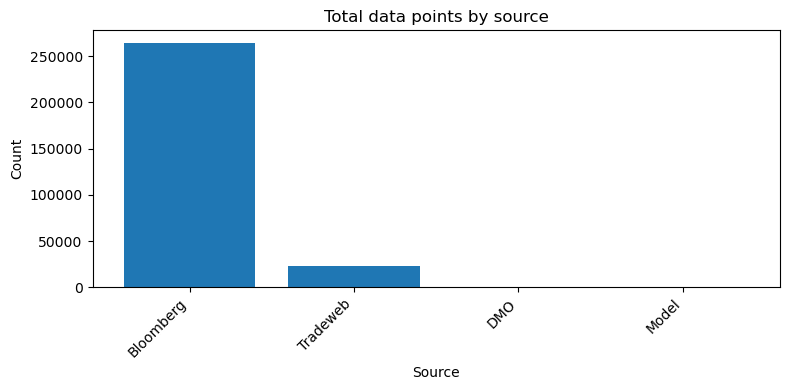

In [17]:
# Counts of data points by source x data_type (with optional filters)

import pandas as pd
from database.db import get_conn

DB_PATH = "jcb_db.db"

def count_points_by_type_and_source(
    db_path: str = DB_PATH,
    *,
    date_from: str | None = None,     # "YYYY-MM-DD"
    date_to: str | None = None,       # "YYYY-MM-DD"
    sources: list[str] | None = None,
    instrument_ids: list[str] | None = None,
    data_types: list[str] | None = None,
    resolution: str | None = None,
):
    where = ["1=1"]
    params: list = []

    if date_from:
        where.append("data_date >= ?")
        params.append(date_from)
    if date_to:
        where.append("data_date <= ?")
        params.append(date_to)
    if resolution:
        where.append("resolution = ?")
        params.append(resolution)
    if sources:
        where.append(f"source IN ({','.join(['?']*len(sources))})")
        params.extend(sources)
    if instrument_ids:
        where.append(f"instrument_id IN ({','.join(['?']*len(instrument_ids))})")
        params.extend(instrument_ids)
    if data_types:
        where.append(f"data_type IN ({','.join(['?']*len(data_types))})")
        params.extend(data_types)

    sql = f"""
        SELECT
            source,
            data_type,
            COUNT(*) AS n
        FROM instrument_data
        WHERE {' AND '.join(where)}
        GROUP BY source, data_type
        ORDER BY source, data_type
    """

    with get_conn(db_path) as conn:
        counts = pd.read_sql_query(sql, conn, params=params)

    # Pivot: rows = source, cols = data_type
    pivot = counts.pivot(index="source", columns="data_type", values="n").fillna(0).astype(int)

    # Add totals
    pivot["TOTAL"] = pivot.sum(axis=1)
    pivot.loc["TOTAL"] = pivot.sum(axis=0)

    # Sort rows by TOTAL (descending), keep TOTAL row last
    total_row = pivot.loc["TOTAL"].copy()
    body = pivot.drop(index="TOTAL").sort_values("TOTAL", ascending=False)
    pivot_sorted = pd.concat([body, total_row.to_frame().T])

    return counts, pivot_sorted

# --- Run it (adjust filters as needed) ---
counts_df, pivot_df = count_points_by_type_and_source(
    db_path=DB_PATH,
    # date_from="2024-01-01",
    # date_to="2025-08-18",
    # sources=["Bloomberg","Tradeweb","DMO"],
    # instrument_ids=["GB00B1VWPJ53", "JCB_ILS_GBP_10Y_RPI"],
    # data_types=["clean_price","dirty_price","yield"],
    # resolution="daily",
)

# Display
print("Counts (long):")
display(counts_df)

print("\nPivot (sources x data_types with totals):")
display(pivot_df)

# Optional: simple bar chart of top sources by total rows
import matplotlib.pyplot as plt

totals = pivot_df.drop(index="TOTAL")["TOTAL"].sort_values(ascending=False)
plt.figure(figsize=(8, 4))
plt.bar(totals.index, totals.values)
plt.title("Total data points by source")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [16]:
# Canonicalise instrument_data.data_type across sources (preview + apply)
import pandas as pd
from database.db import get_conn

DB_PATH = "jcb_db.db"
APPLY_CHANGES = True  # set True to apply the migration

# 1) Ensure mapping table exists
ensure_sql = """
CREATE TABLE IF NOT EXISTS data_type_map (
    source TEXT NOT NULL,
    raw_data_type TEXT NOT NULL,
    canonical_data_type TEXT NOT NULL,
    default_unit TEXT,
    note TEXT,
    PRIMARY KEY (source, raw_data_type)
);
"""

# 2) Seed mappings tailored to what you have now
# Feel free to add more as you discover variants.
seed_rows = [
    # source,     raw_data_type                 -> canonical,         unit,       note
    ("Bloomberg", "price",                       "clean_price",       "per_100",  "PX_LAST ~ clean price for bonds"),
    ("Bloomberg", "amount_outstanding_history",  "amount_outstanding",None,       "history series canonicalised"),

    ("Tradeweb",  "duration_modified",           "modified_duration", "years",    ""),
    # The following are already canonical; leaving here as explicit docs/guards (no harm)
    ("Tradeweb",  "clean_price",                 "clean_price",       "per_100",  ""),
    ("Tradeweb",  "dirty_price",                 "dirty_price",       "per_100",  ""),
    ("Tradeweb",  "yield",                       "yield",             "percent",  ""),
    ("Tradeweb",  "accrued_interest",            "accrued_interest",  "per_100",  ""),

    ("DMO",       "amount_outstanding",          "amount_outstanding",None,       ""),
    ("Model",     "clean_price",                 "clean_price",       "per_100",  ""),

    # Generic catch-alls you might encounter later
    ("*",         "price_clean",                 "clean_price",       "per_100",  ""),
    ("*",         "cleanprice",                  "clean_price",       "per_100",  ""),
    ("*",         "price_dirty",                 "dirty_price",       "per_100",  ""),
    ("*",         "dirtyprice",                  "dirty_price",       "per_100",  ""),
]

upsert_sql = """
INSERT INTO data_type_map (source, raw_data_type, canonical_data_type, default_unit, note)
VALUES (?, ?, ?, ?, ?)
ON CONFLICT(source, raw_data_type) DO UPDATE SET
  canonical_data_type = excluded.canonical_data_type,
  default_unit        = excluded.default_unit,
  note                = excluded.note;
"""

# 3) Build preview of mapping effect (do not mutate instrument_data yet)
preview_sql = """
WITH mapped AS (
  SELECT
    d.instrument_id,
    d.data_date,
    d.data_type AS raw_type,
    d.source,
    d.resolution,
    d.value,
    d.unit,
    d.attrs,
    COALESCE(m1.canonical_data_type, m2.canonical_data_type, d.data_type) AS canonical_type,
    COALESCE(d.unit, m1.default_unit, m2.default_unit) AS canonical_unit
  FROM instrument_data d
  LEFT JOIN data_type_map m1
    ON LOWER(m1.source) = LOWER(d.source) AND m1.raw_data_type = d.data_type
  LEFT JOIN data_type_map m2
    ON m2.source = '*' AND m2.raw_data_type = d.data_type
)
SELECT * FROM mapped;
"""

# 4) Normalisation DDL/DML (build new table, aggregate duplicates), then swap
build_norm_sql = """
DROP TABLE IF EXISTS instrument_data_norm;

CREATE TABLE instrument_data_norm (
  instrument_id TEXT NOT NULL,
  data_date DATE NOT NULL,
  data_type TEXT NOT NULL,
  value REAL,
  source TEXT,
  resolution TEXT,
  unit TEXT,
  attrs TEXT,
  PRIMARY KEY (instrument_id, data_date, data_type, source, resolution)
);

WITH mapped AS (
  SELECT
    d.instrument_id,
    d.data_date,
    COALESCE(m1.canonical_data_type, m2.canonical_data_type, d.data_type) AS canonical_type,
    d.value,
    d.source,
    d.resolution,
    COALESCE(d.unit, m1.default_unit, m2.default_unit) AS canonical_unit,
    d.attrs
  FROM instrument_data d
  LEFT JOIN data_type_map m1
    ON LOWER(m1.source) = LOWER(d.source) AND m1.raw_data_type = d.data_type
  LEFT JOIN data_type_map m2
    ON m2.source = '*' AND m2.raw_data_type = d.data_type
)
INSERT INTO instrument_data_norm (instrument_id, data_date, data_type, value, source, resolution, unit, attrs)
SELECT
  instrument_id,
  data_date,
  canonical_type,
  MAX(value)    AS value,       -- deterministic collapse if duplicates
  source,
  resolution,
  MAX(canonical_unit) AS unit,
  MAX(attrs)    AS attrs
FROM mapped
GROUP BY instrument_id, data_date, canonical_type, source, resolution;
"""

swap_sql = """
ALTER TABLE instrument_data RENAME TO instrument_data_old;
ALTER TABLE instrument_data_norm RENAME TO instrument_data;
DROP TABLE instrument_data_old;
"""

# ---- Run (preview first) ----
with get_conn(DB_PATH) as conn:
    # ensure map table + seed
    conn.execute(ensure_sql)
    conn.executemany(upsert_sql, seed_rows)

    # before snapshot
    print("Before (counts by source, data_type):")
    before = pd.read_sql_query("""
        SELECT source, data_type, COUNT(*) AS n
        FROM instrument_data
        GROUP BY source, data_type
        ORDER BY source, data_type
    """, conn)
    display(before)

    # preview mapping result (in-memory via temp view)
    mapped = pd.read_sql_query(preview_sql, conn)

    # deltas: what would change?
    delta = (
        mapped.assign(changed=lambda x: x["raw_type"] != x["canonical_type"])
              .groupby(["source", "raw_type", "canonical_type"], as_index=False)
              .agg(n=("instrument_id","count"))
              .sort_values(["source","n"], ascending=[True, False])
    )
    print("\nPreview of remaps (raw_type → canonical_type):")
    display(delta)

    # potential collisions after mapping
    collisions = (
        mapped
        .groupby(["instrument_id","data_date","canonical_type","source","resolution"], as_index=False)
        .size()
    )
    collisions = collisions[collisions["size"] > 1].sort_values("size", ascending=False)
    print("\nPotential collisions after mapping (same key becomes >1 row):")
    display(collisions.head(20))
    print(f"Total collision groups: {len(collisions)}")

    # apply changes if requested
    if APPLY_CHANGES:
        conn.executescript(build_norm_sql)
        conn.executescript(swap_sql)
        print("\n✅ Applied normalisation and swapped instrument_data.")

        after = pd.read_sql_query("""
            SELECT source, data_type, COUNT(*) AS n
            FROM instrument_data
            GROUP BY source, data_type
            ORDER BY source, data_type
        """, conn)
        print("\nAfter (counts by source, data_type):")
        display(after)
    else:
        print("\n🧪 Preview only (set APPLY_CHANGES=True to apply).")


Before (counts by source, data_type):


,source,data_type,n
0,Bloomberg,amount_outstanding_history,1510
1,Bloomberg,price,94996
2,Bloomberg,yield,168144
3,DMO,amount_outstanding,101
4,Model,clean_price,1
5,Tradeweb,accrued_interest,4504
6,Tradeweb,clean_price,6154
7,Tradeweb,dirty_price,5398
8,Tradeweb,duration_modified,264
9,Tradeweb,yield,6150



Preview of remaps (raw_type → canonical_type):


,source,raw_type,canonical_type,n
2,Bloomberg,yield,yield,168144
1,Bloomberg,price,clean_price,94996
0,Bloomberg,amount_outstanding_history,amount_outstanding,1510
3,DMO,amount_outstanding,amount_outstanding,101
4,Model,clean_price,clean_price,1
6,Tradeweb,clean_price,clean_price,6154
9,Tradeweb,yield,yield,6150
7,Tradeweb,dirty_price,dirty_price,5398
5,Tradeweb,accrued_interest,accrued_interest,4504
8,Tradeweb,duration_modified,modified_duration,264



Potential collisions after mapping (same key becomes >1 row):


,instrument_id,data_date,canonical_type,source,resolution,size


Total collision groups: 0

✅ Applied normalisation and swapped instrument_data.

After (counts by source, data_type):


,source,data_type,n
0,Bloomberg,amount_outstanding,1510
1,Bloomberg,clean_price,94996
2,Bloomberg,yield,168144
3,DMO,amount_outstanding,101
4,Model,clean_price,1
5,Tradeweb,accrued_interest,4504
6,Tradeweb,clean_price,6154
7,Tradeweb,dirty_price,5398
8,Tradeweb,modified_duration,264
9,Tradeweb,yield,6150


In [30]:
# ========= Config =========
DB_PATH       = "jcb_db.db"
MAX_ISINS     = 8        # how many ISINs to test
N_DATES       = 20       # last N overlapping dates per ISIN
EXDIV_BDAYS   = 7        # ex-div window (UK gilts)
SAVE_STEM     = "recon_bbg_vs_tradeweb"  # two CSVs will be created with this stem

# ========= Helpers (SQL + series loaders) — uses database.db.get_conn and instruments.isin =========
from database.db import get_conn
import pandas as pd

PREF_PRICE_DTYPES = {
    "Bloomberg": ("price_clean", "clean_price", "price"),
    "Tradeweb":  ("clean_price", "price_clean", "price"),
}

def _pick_price_dtype(conn, isin, source):
    dts = pd.read_sql_query("""
        SELECT DISTINCT data_type
        FROM instrument_data
        WHERE instrument_id=? AND source=? AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
    """, conn, params=[isin, source])["data_type"].tolist()
    for k in PREF_PRICE_DTYPES[source]:
        if k in dts: return k
    return None

def _load_price_series(conn, isin, source, dtype_hint=None):
    """Return (df: data_date, clean_close). If no clean/price exists and source=Tradeweb, try dirty - AI."""
    if dtype_hint is None:
        dtype_hint = _pick_price_dtype(conn, isin, source)

    if dtype_hint is not None:
        px = pd.read_sql_query(f"""
            SELECT data_date, value AS clean_close
            FROM instrument_data
            WHERE instrument_id=? AND source=? AND data_type=? AND resolution='daily'
              AND json_extract(attrs,'$.session')='close'
            ORDER BY data_date
        """, conn, params=[isin, source, dtype_hint])
        if not px.empty:
            px["data_date"] = pd.to_datetime(px["data_date"])
            return px

    # Fallback for Tradeweb: CLEAN ≈ DIRTY - AI (same date)
    if source == "Tradeweb":
        dirty = pd.read_sql_query("""
            SELECT data_date, value AS dirty
            FROM instrument_data
            WHERE instrument_id=? AND source='Tradeweb' AND data_type='dirty_price'
              AND resolution='daily' AND json_extract(attrs,'$.session')='close'
            ORDER BY data_date
        """, conn, params=[isin])
        ai = pd.read_sql_query("""
            SELECT data_date, value AS ai
            FROM instrument_data
            WHERE instrument_id=? AND source='Tradeweb' AND data_type='accrued_interest'
              AND resolution='daily' AND json_extract(attrs,'$.session')='close'
            ORDER BY data_date
        """, conn, params=[isin])
        if not dirty.empty and not ai.empty:
            df = pd.merge(dirty, ai, on="data_date", how="inner")
            if not df.empty:
                df["clean_close"] = df["dirty"] - df["ai"]
                df = df[["data_date","clean_close"]]
                df["data_date"] = pd.to_datetime(df["data_date"])
                return df

    return pd.DataFrame(columns=["data_date","clean_close"])

def _load_yield_series(conn, isin, source):
    y = pd.read_sql_query("""
        SELECT data_date, value AS y_close_pct
        FROM instrument_data
        WHERE instrument_id=? AND source=? AND data_type='yield' AND resolution='daily'
          AND json_extract(attrs,'$.session')='close'
        ORDER BY data_date
    """, conn, params=[isin, source])
    y["data_date"] = pd.to_datetime(y["data_date"])
    return y

def _eligible_isins(conn, limit=MAX_ISINS):
    """
    Conventional UK bonds where BOTH sources have yield+price close,
    and latest price < maturity. Uses instruments.isin (PK).
    """
    sql = """
    SELECT i.isin AS instrument_id
    FROM instruments i
    WHERE i.country='UK' AND i.instrument_type='bond' AND IFNULL(i.is_linker,0)=0
      AND EXISTS (
        SELECT 1 FROM instrument_data y
        WHERE y.instrument_id=i.isin AND y.source='Bloomberg'
          AND y.data_type='yield' AND y.resolution='daily'
          AND json_extract(y.attrs,'$.session')='close'
      )
      AND EXISTS (
        SELECT 1 FROM instrument_data y2
        WHERE y2.instrument_id=i.isin AND y2.source='Tradeweb'
          AND y2.data_type='yield' AND y2.resolution='daily'
          AND json_extract(y2.attrs,'$.session')='close'
      )
      AND EXISTS (
        SELECT 1 FROM instrument_data p
        WHERE p.instrument_id=i.isin AND p.source IN ('Bloomberg','Tradeweb')
          AND p.data_type IN ('price_clean','clean_price','price','dirty_price')
          AND p.resolution='daily'
          AND json_extract(p.attrs,'$.session')='close'
      )
      AND (
        SELECT MAX(p2.data_date) FROM instrument_data p2
        WHERE p2.instrument_id=i.isin
          AND p2.source IN ('Bloomberg','Tradeweb')
          AND p2.data_type IN ('price_clean','clean_price','price','dirty_price')
          AND p2.resolution='daily'
          AND json_extract(p2.attrs,'$.session')='close'
      ) < IFNULL(i.maturity_date, '9999-12-31')
    ORDER BY (
      SELECT MIN(
        (SELECT MAX(pB.data_date) FROM instrument_data pB
           WHERE pB.instrument_id=i.isin AND pB.source='Bloomberg'
             AND pB.data_type IN ('price_clean','clean_price','price')
             AND pB.resolution='daily'
             AND json_extract(pB.attrs,'$.session')='close'),
        (SELECT MAX(pT.data_date) FROM instrument_data pT
           WHERE pT.instrument_id=i.isin AND pT.source='Tradeweb'
             AND pT.data_type IN ('price_clean','clean_price','price','dirty_price')
             AND pT.resolution='daily'
             AND json_extract(pT.attrs,'$.session')='close')
      ) DESC
    ) DESC
    LIMIT ?
    """
    return pd.read_sql_query(sql, conn, params=[int(limit)])

# ---- Load aligned series for both sources per ISIN ----
with get_conn(DB_PATH) as conn:
    cand = _eligible_isins(conn, MAX_ISINS)
    assert not cand.empty, "No eligible ISINs with both Bloomberg and Tradeweb close series found."
    ISINS = cand["instrument_id"].tolist()

    pairs = {}  # isin -> merged df with columns: date, bbg_clean, bbg_y, tw_clean, tw_y
    for isin in ISINS:
        px_bbg = _load_price_series(conn, isin, "Bloomberg")
        y_bbg  = _load_yield_series(conn, isin, "Bloomberg")
        px_tw  = _load_price_series(conn, isin, "Tradeweb")
        y_tw   = _load_yield_series(conn, isin, "Tradeweb")

        bbg = pd.merge(px_bbg, y_bbg, on="data_date", how="inner")
        tw  = pd.merge(px_tw,  y_tw,  on="data_date", how="inner")
        if bbg.empty or tw.empty:
            continue

        m = pd.merge(
            bbg.rename(columns={"data_date":"date","clean_close":"bbg_clean","y_close_pct":"bbg_y"}),
            tw.rename(columns={"data_date":"date","clean_close":"tw_clean","y_close_pct":"tw_y"}),
            on="date", how="inner"
        )
        if m.empty:
            continue

        pairs[isin] = m.sort_values("date")

print(f"Prepared aligned series for {len(pairs)} ISIN(s).")
if pairs:
    first_isin = next(iter(pairs))
    print("Example ISIN:", first_isin)
    display(pairs[first_isin].tail(10))



Prepared aligned series for 8 ISIN(s).
Example ISIN: GB00BL68HJ26


,date,bbg_clean,bbg_y,tw_clean,tw_y
5,2025-07-07,98.278,3.249,98.282,3.223641
6,2025-07-14,98.363,3.199,98.363,3.178724
7,2025-07-15,98.363,3.215,98.360,3.199849
8,2025-07-16,98.363,3.231,98.354,3.226939
9,2025-07-17,98.348,3.276,98.352,3.246601
10,2025-07-18,98.375,3.273,98.371,3.257906
11,2025-07-21,98.408,3.225,98.404,3.209440
12,2025-07-22,98.425,3.207,98.426,3.182126
13,2025-07-23,98.411,3.252,98.423,3.204142
14,2025-07-24,98.434,3.223,98.433,3.200459


In [ ]:
from datetime import timedelta
import pandas as pd
from database.db import get_conn

# project deps
from utils.jcb_calendar import BusinessDayCalendar
from database.query import get_holidays_for_calendar

assert 'CashflowModel' in globals(), "Import or define CashflowModel first."

# Calendar (pass the connection into your query function)
with get_conn(DB_PATH) as conn:
    uk = BusinessDayCalendar(set(get_holidays_for_calendar(conn, "UK")))

def prev_bday(d): return uk.previous_business_day(d)

def safe_settle(d, maturity_dt):
    d = pd.to_datetime(d).date()
    return prev_bday(maturity_dt) if d >= maturity_dt else d

def load_terms(conn, isin):
    row = pd.read_sql_query("""
        SELECT isin, first_issue_date, maturity_date, coupon_rate, first_coupon_length, is_linker
        FROM instruments WHERE isin=?
    """, conn, params=[isin]).iloc[0]
    assert int(row["is_linker"] or 0) == 0, "Linker encountered."
    return (
        pd.to_datetime(row["first_issue_date"]).date(),
        pd.to_datetime(row["maturity_date"]).date(),
        float(row["coupon_rate"]),
        row["first_coupon_length"] or None
    )

def reconcile_isin(isin, df_aligned, n_dates=N_DATES, exdiv=EXDIV_BDAYS):
    """df_aligned has columns: date, bbg_clean, bbg_y, tw_clean, tw_y (y in percent)."""
    with get_conn(DB_PATH) as conn:
        issue_dt, maturity_dt, coupon, first_stub = load_terms(conn, isin)

    live = df_aligned[df_aligned["date"].dt.date < maturity_dt].copy()
    if live.empty:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    live = live.tail(int(n_dates)).copy()
    live["settlement"] = live["date"].dt.date.map(lambda d: safe_settle(d, maturity_dt))

    model = CashflowModel(
        issue_date=issue_dt,
        maturity_date=maturity_dt,
        coupon_rate=coupon,
        frequency=2,
        calendar=uk,
        convention="mf",
        first_coupon_length=first_stub,
    )

    f = model.frequency
    min_y = -0.99 * f + 1e-9

    rows_long, rows_pair = [], []

    # Per-source reconciliation
    for src in ("Bloomberg","Tradeweb"):
        px_col = "bbg_clean" if src=="Bloomberg" else "tw_clean"
        y_col  = "bbg_y"     if src=="Bloomberg" else "tw_y"
        for _, r in live.iterrows():
            settle = r["settlement"]
            px_obs = float(r[px_col])
            y_obs  = float(r[y_col]) / 100.0

            # Yield -> Price (model)
            px_from_y = model.clean_price_from_yield(y_obs, settle, ex_div_business_days=EXDIV_BDAYS)

            # Price -> Yield (bracket around observed yield ±200 bps)
            lo = max(min_y, y_obs - 0.02); hi = y_obs + 0.02
            y_from_px = model.yield_from_clean_price(px_obs, settle, ex_div_business_days=EXDIV_BDAYS, bracket=(lo, hi))

            rows_long.append({
                "instrument_id": isin,
                "source": src,
                "date": settle,
                "obs_clean": px_obs,
                "obs_yield_pct": y_obs*100.0,
                "model_px_from_obs_y": px_from_y,
                "px_err_cents": (px_from_y - px_obs)*100.0,
                "model_y_from_obs_px_pct": y_from_px*100.0,
                "yield_diff_bps": (y_from_px - y_obs)*1e4,
                "AI": model.accrued_interest(settle),
            })

    # Observed BBG vs TW diffs on same dates
    for _, r in live.iterrows():
        rows_pair.append({
            "instrument_id": isin,
            "date": r["settlement"],
            "bbg_clean": float(r["bbg_clean"]),
            "tw_clean":  float(r["tw_clean"]),
            "clean_diff_cents": (float(r["bbg_clean"]) - float(r["tw_clean"])) * 100.0,
            "bbg_yield_pct": float(r["bbg_y"]),
            "tw_yield_pct":  float(r["tw_y"]),
            "yield_diff_bps": (float(r["bbg_y"]) - float(r["tw_y"])) * 100.0,
        })

    return pd.DataFrame(rows_long), pd.DataFrame(rows_pair), live[["date","settlement"]].copy()

# ---- Run across ISINs, aggregate, and save CSVs ----
long_rows, pair_rows, meta_rows = [], [], []

for isin, df_aligned in pairs.items():
    try:
        df_long, df_pair, meta = reconcile_isin(isin, df_aligned, N_DATES, EXDIV_BDAYS)
        if not df_long.empty: long_rows.append(df_long)
        if not df_pair.empty: pair_rows.append(df_pair)
        if not meta.empty:
            m = meta.copy(); m["instrument_id"] = isin; meta_rows.append(m)
    except Exception as e:
        print(f"⚠️ {isin}: {e}")

recon_long = pd.concat(long_rows, ignore_index=True) if long_rows else pd.DataFrame()
recon_pair = pd.concat(pair_rows, ignore_index=True) if pair_rows else pd.DataFrame()

print(f"Rows (per-source long): {len(recon_long)}")
print(f"Rows (BBG vs TW pairs): {len(recon_pair)}")

if not recon_long.empty or not recon_pair.empty:
    per_source_csv = f"{SAVE_STEM}_per_source.csv"
    pair_csv       = f"{SAVE_STEM}_bbg_vs_tw.csv"
    recon_long.to_csv(per_source_csv, index=False)
    recon_pair.to_csv(pair_csv, index=False)
    print("Saved:")
    print("  -", per_source_csv)
    print("  -", pair_csv)

# ---- Summaries ----
if not recon_long.empty:
    print("\nPer-source model reconciliation summary (abs errors):")
    summ = recon_long.groupby("source").agg(
        rows=("date","count"),
        px_med_abs_cents=("px_err_cents", lambda s: s.abs().median()),
        px_max_abs_cents=("px_err_cents", lambda s: s.abs().max()),
        y_med_abs_bps=("yield_diff_bps", lambda s: s.abs().median()),
        y_max_abs_bps=("yield_diff_bps", lambda s: s.abs().max()),
    ).sort_values("px_med_abs_cents")
    display(summ)

if not recon_pair.empty:
    print("\nObserved BBG vs TW diffs (abs):")
    sp = recon_pair.agg({
        "clean_diff_cents": ["median","max", lambda s: s.abs().median(), lambda s: s.abs().max()],
        "yield_diff_bps":   ["median","max", lambda s: s.abs().median(), lambda s: s.abs().max()],
    }).T
    sp.columns = ["median","max","abs_median","abs_max"]
    display(sp)

# Peek
if not recon_long.empty:
    print("\nSample (per-source):"); display(recon_long.tail(10))
if not recon_pair.empty:
    print("\nSample (BBG vs TW pairs):"); display(recon_pair.tail(10))


TypeError: 'str' object does not support the context manager protocol

In [25]:
import sys, importlib
sys.path.append("/Users/jcb/Documents/bond_project")  # adjust if your project root differs

CashflowModel = None
_candidates = [
    ("cashflow_model.conv_bond_model", "CashflowModel"),
    ("cashflow_model.conventional_bond_cashflow_model", "CashflowModel"),
    ("cashflow_model.cashflow_model", "CashflowModel"),
    ("cashflow_model.models", "CashflowModel"),
    # in case your class is named differently:
    ("cashflow_model.conv_bond_model", "ConventionalBondModel"),
]

for modpath, clsname in _candidates:
    try:
        mod = importlib.import_module(modpath)
        if hasattr(mod, clsname):
            CashflowModel = getattr(mod, clsname)
            print(f"✅ Imported {clsname} from {modpath}")
            break
    except Exception:
        pass

if CashflowModel is None:
    raise ImportError(
        "Couldn't import CashflowModel. Check the module path/name in your project. "
        "If your class has a different name, add it to the _candidates list."
    )

✅ Imported CashflowModel from cashflow_model.conv_bond_model
